## Imports

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn. metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
!pip install mlxtend

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### Read data into DFs

In [202]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

In [203]:
#strip whitespace

def data_to_str(df):
    """
    Strip leading/trailing spaces from all string (object) columns.
    """
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

In [204]:
def strip_whitespace(df):
    
    # Remove trailing period if present
    df['pred'] = df['pred'].str.rstrip('.')

    return df

In [205]:
def replace_qmarks(df):
    
    # Convert "?" to missing values (NaN) in both dataframes
    df.replace("?", np.nan, inplace=True)

    return df

In [206]:
#convert numeric columns to integer types

def data_to_int32(df):
    """
    Convert known numeric columns to int32 (or Int64 if you want to allow NaN).
    """
    int_cols = [
        'age',
        'fnlwgt',
        'education-num',
        'capital-gain',
        'capital-loss',
        'hours-per-week'
    ]
    for col in int_cols:
        df[col] = df[col].astype('int32')
        
    return df

In [207]:
def preprocessing(df):

    df = data_to_str(df)
    df = strip_whitespace(df)
    df = replace_qmarks(df)
    df = data_to_int32(df)
    df = df.drop_duplicates()

    return df

In [208]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [209]:
chart_df = train_df.copy()

chart_df['pred'] = np.where(chart_df['pred'] == '>50K',1,0)

chart_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [210]:
def plot_prevalence_subplots(df, categories, pred_col='pred'):
    n = len(categories)
    rows = (n + 2) // 3          # auto-fit 3 plots per row
    cols = min(n, 3)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, cat in enumerate(categories):
        ax = axes[i]
        
        prevalence = df.groupby(cat)[pred_col].mean()

        prevalence.plot(kind='bar', ax=ax)

        ax.set_title(f"Target prevalence by '{cat}' group")
        ax.set_ylabel("Proportion with target = 1")
        ax.set_xlabel(cat)

    # Hide unused subplots (if any)
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

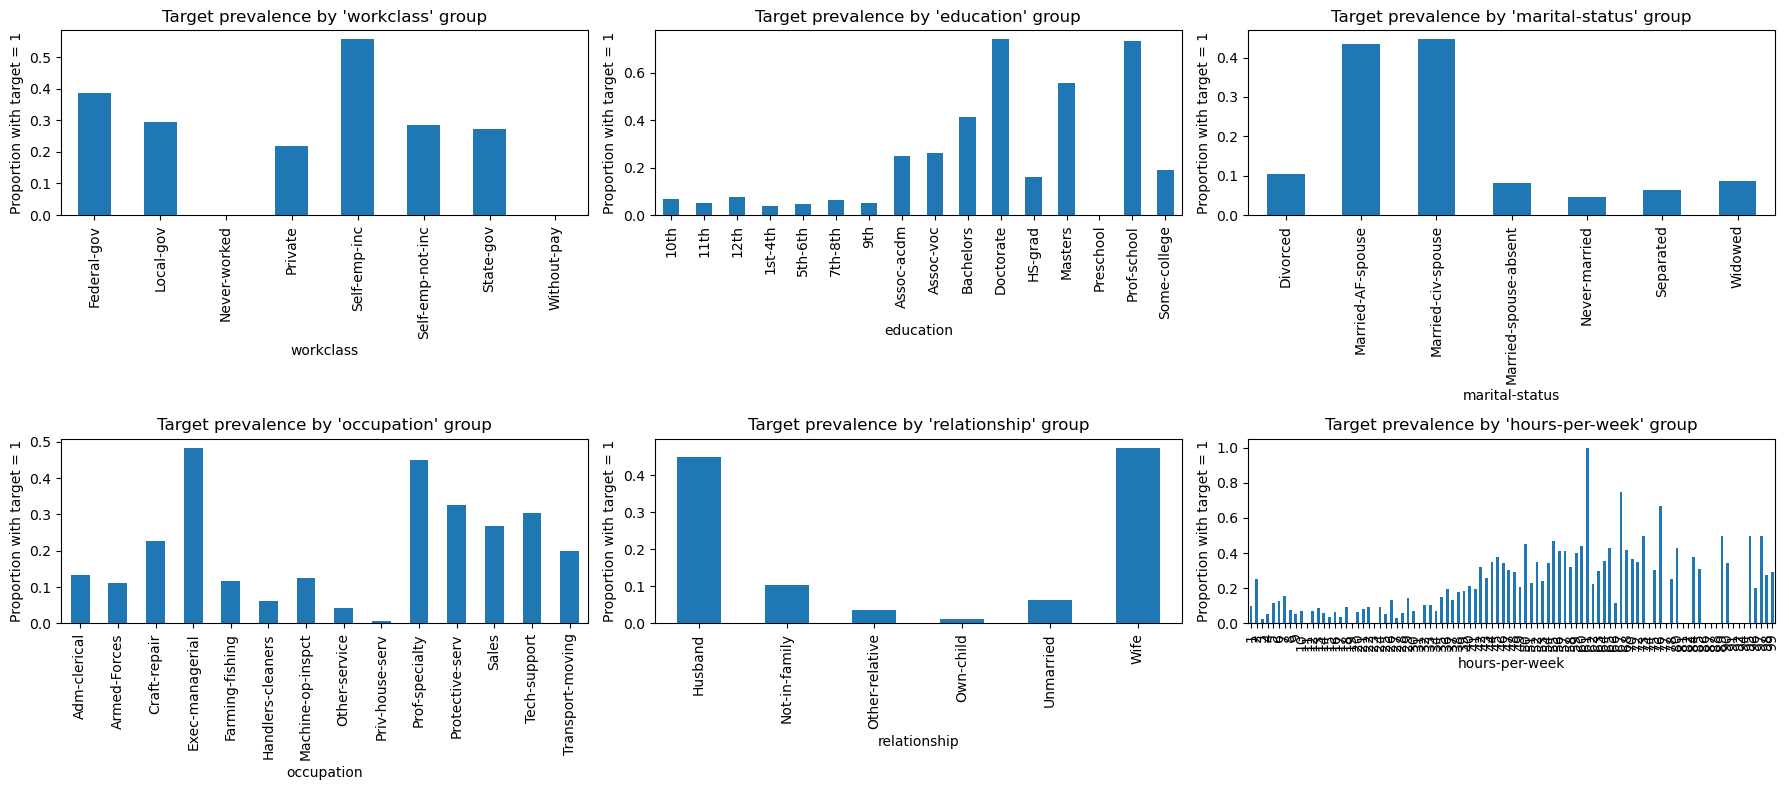

In [211]:
cats = ['workclass','education','marital-status','occupation','relationship','hours-per-week']

plot_prevalence_subplots(chart_df, cats)

## Recategorize the Categorical features into more meaningful groups

In [212]:
def category_remapping(df):

    copy_df = df.copy()
    
    workclass_mapping = {
        'State-gov':'Government',
        'Local-gov':'Government',
        'Federal-gov':'Government',
        'Self-emp-inc':'Incorporated-Entrepreneur',
        'Self-emp-not-inc':'Unincorporated-Entrepreneur',
        'Without-pay':'Unemployed',
        'Never-worked':'Unemployed',
        'Private':'Private'
    }
    
    # Apply mapping and insert into dataframe
    copy_df.insert(2,'workclass-cat',copy_df['workclass'].map(workclass_mapping))
    
    edu_mapping = {
        'Preschool':'HS-dropout',
        '1st-4th':'HS-dropout',
        '5th-6th':'HS-dropout',
        '7th-8th':'HS-dropout',
        '9th':'HS-dropout',
        '10th':'HS-dropout',
        '11th':'HS-dropout',
        '12th':'HS-dropout',
        'HS-grad':'HS-grad',
        'Some-college':'Some-college',
        'Assoc-acdm':'Some-college',
        'Assoc-voc':'Some-college',
        'Bachelors':'Bachelors',
        'Masters':'Advanced-degree',
        'Prof-school':'Advanced-degree',
        'Doctorate':'Advanced-degree'
    }
    
    copy_df.insert(4,"education-cat",copy_df['education'].map(edu_mapping))
    
    marital_mapping = {
        'Never-married':'Single/Unmarried',
        'Divorced':'Single/Unmarried',
        'Separated':'Single/Unmarried',
        'Widowed':'Single/Unmarried',
        'Married-spouse-absent':'Single/Unmarried',
        'Married-civ-spouse':'Married',
        'Married-AF-spouse':'Married'
    }
    
    copy_df.insert(7,'marital-cat',copy_df['marital-status'].map(marital_mapping))

    occupation_mapping = {
        'Exec-managerial':'White-collar',
        'Prof-specialty':'White-collar',
        'Tech-support':'White-collar',
        
        'Other-service':'Service',
        'Sales':'Service',
        'Adm-clerical':'Service',
        'Protective-serv':'Service',
        
        'Craft-repair':'Blue-collar',
        'Transport-moving':'Blue-collar',
        'Machine-op-inspct':'Blue-collar',
    
        'Armed-Forces':'Military',
    
        'Priv-house-serv':'Manual',
        'Farming-fishing':'Manual',
        'Handlers-cleaners':'Manual'
    }
    
    copy_df.insert(10,'occupation-cat',copy_df['occupation'].map(occupation_mapping))

    s = copy_df['native-country']
    
    native_imm_cat = (
        s.map({'United-States': 'Native'})         # US → Native, others → NaN
         .fillna('Immigrant')                     # non-US, non-missing → Immigrant
         .where(s.notna(), pd.NA)                 # where original was missing, keep NA
    )
    
    native_imm_cat.replace({pd.NA:np.nan}, inplace = True)
    
    copy_df.insert(18, 'native_imm_cat', native_imm_cat)

    hrs_bins = [0, 30, 40, 60, 100]
    hrs_labels = ['Part-Time', 'Underworked', 'Full-Time+', 'Overworked']
    
    copy_df['hours_bin'] = pd.cut(
        copy_df['hours-per-week'], 
        bins=hrs_bins, 
        labels=hrs_labels
    )
    
    age_bins = [0, 29, 39, 49, 59, 69, 120]
    age_labels = ['Under 30', '30s', '40s', '50s', '60s', '70s+']

    copy_df['age_group'] = pd.cut(
    copy_df['age'],
    bins=age_bins,
    labels=age_labels
    )
    
   

    # drop all adjusted categorical features in favor of their derived categories
    copy_df.drop(['workclass','fnlwgt','education','education-num','marital-status','occupation','native-country','hours-per-week','age'], axis = 1, inplace = True)

    return copy_df

In [213]:
train_df = category_remapping(train_df)
test_df = category_remapping(test_df)

chart_df = train_df.copy()

chart_df['pred'] = np.where(chart_df['pred'] == '>50K',1,0)

/var/folders/25/f17gdg150f3cf0_p319qnrcw0000gn/T/ipykernel_987/2672986501.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df.groupby(cat)[pred_col].mean()
/var/folders/25/f17gdg150f3cf0_p319qnrcw0000gn/T/ipykernel_987/2672986501.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df.groupby(cat)[pred_col].mean()


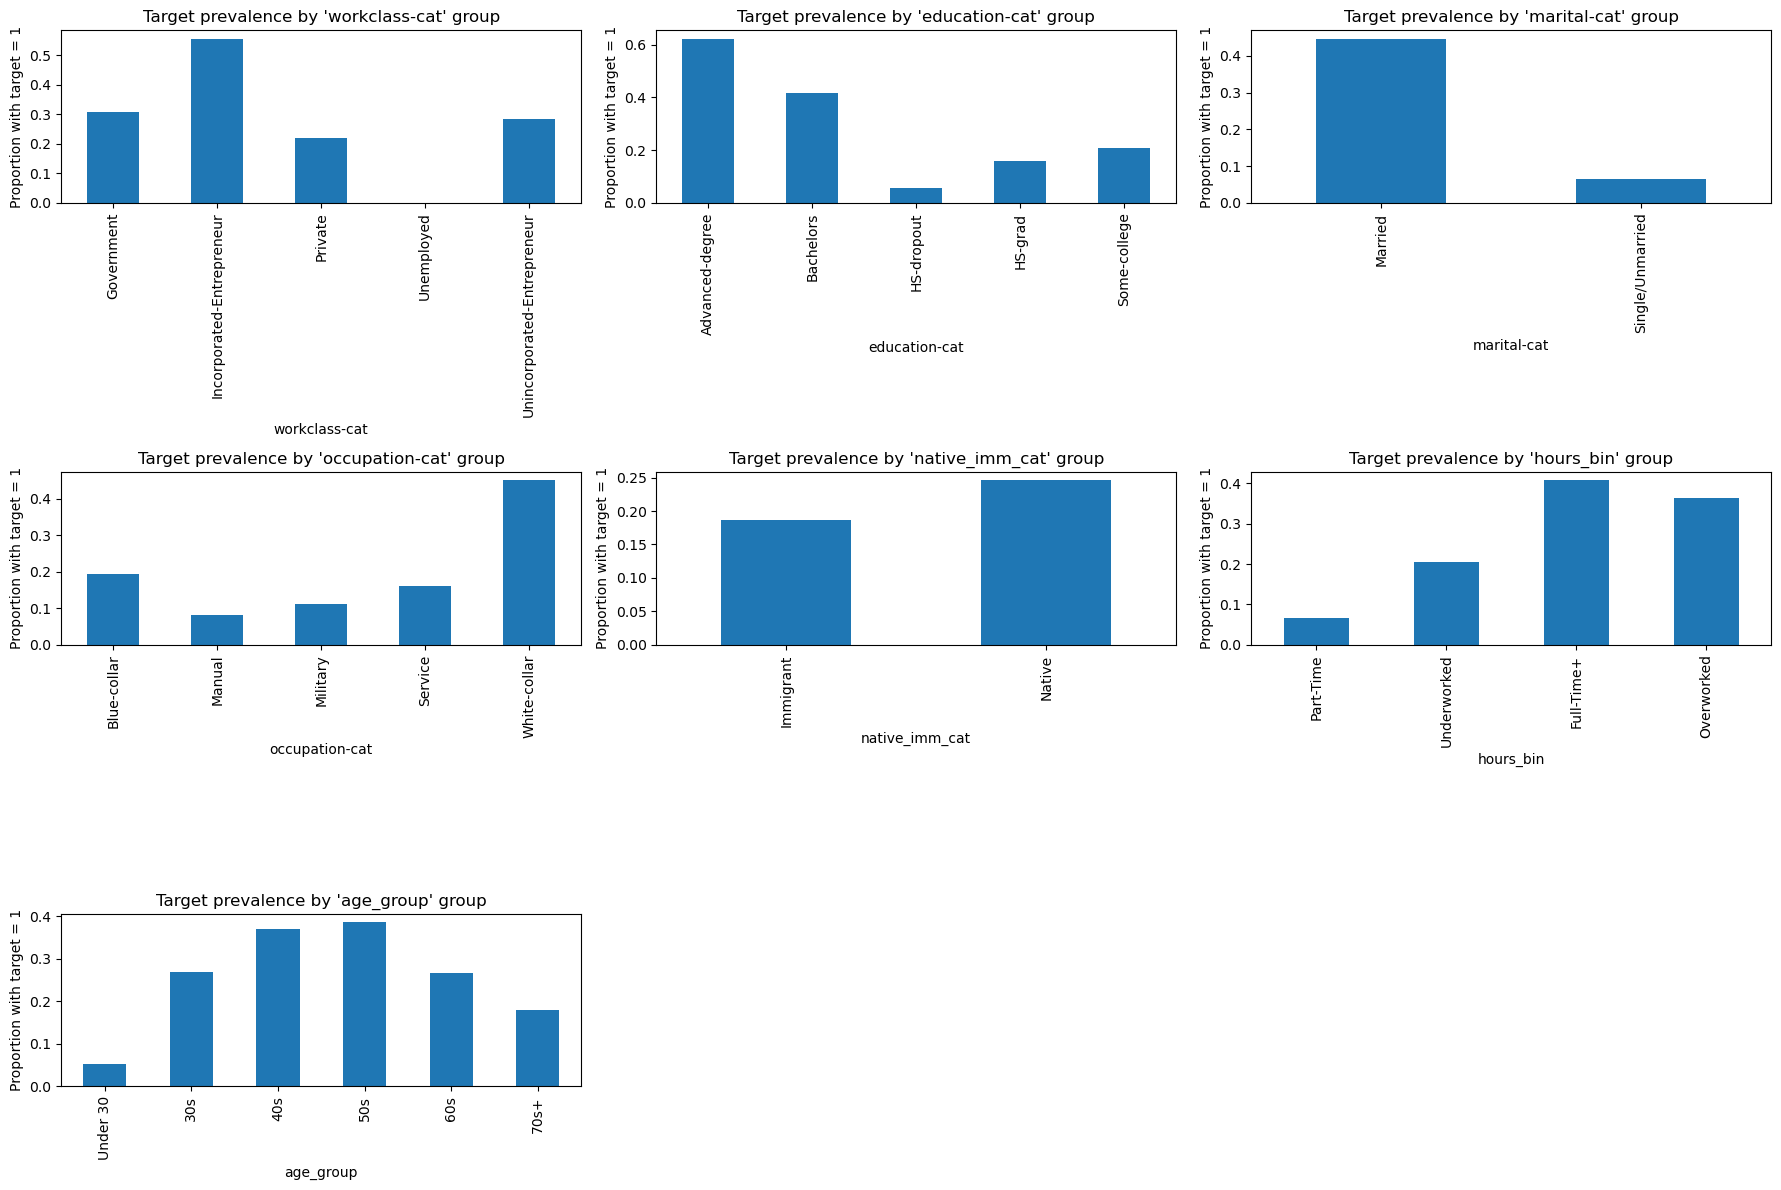

In [214]:
cats = ['workclass-cat','education-cat','marital-cat','occupation-cat','native_imm_cat','hours_bin','age_group']

plot_prevalence_subplots(chart_df, cats)

## Missing Values

In [215]:
train_df.isna().sum()

workclass-cat     1836
education-cat        0
marital-cat          0
occupation-cat    1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
native_imm_cat     582
pred                 0
hours_bin            0
age_group            0
dtype: int64

In [216]:
test_df.isna().sum()

workclass-cat     963
education-cat       0
marital-cat         0
occupation-cat    966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
native_imm_cat    274
pred                0
hours_bin           0
age_group           0
dtype: int64

In [217]:
#Columns that have missing values
columns = {'workclass-cat', 'occupation-cat', 'native_imm_cat'}
columns_test = {'workclass-cat', 'occupation-cat', 'native_imm_cat'}


In [218]:
cat_impute_train = ['workclass-cat', 'occupation-cat', 'native_imm_cat']
cat_impute_test  = ['workclass-cat', 'occupation-cat', 'native_imm_cat', 'education-cat', 'marital-cat']


In [219]:
#Print only the columns that contain NA values
for col in columns:
    if train_df[col].isna().any():
        print(f"\n{col}")
        print(train_df[col].unique())


native_imm_cat
['Native' 'Immigrant' nan]

workclass-cat
['Government' 'Unincorporated-Entrepreneur' 'Private' nan
 'Incorporated-Entrepreneur' 'Unemployed']

occupation-cat
['Service' 'White-collar' 'Manual' 'Blue-collar' nan 'Military']


In [220]:
##### TRAIN
#Imputation: mode - 2
train_df_mode = train_df.copy()
for col in cat_impute_train:
    train_df_mode[col] = train_df_mode[col].fillna(train_df_mode[col].mode()[0])
#for col in columns:
    #train_df_mode[col] = train_df_mode[col].fillna(train_df_mode[col].mode()[0])

train_df_mode.isna().sum()

workclass-cat     0
education-cat     0
marital-cat       0
occupation-cat    0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
native_imm_cat    0
pred              0
hours_bin         0
age_group         0
dtype: int64

In [221]:
#### TEST
#Imputation: mode - 2
test_df_mode = test_df.copy()

for col in cat_impute_test:
    test_df_mode[col] = test_df_mode[col].fillna(test_df_mode[col].mode()[0])
#for col in columns_test:
   # test_df_mode[col] = test_df_mode[col].fillna(test_df_mode[col].mode()[0])

test_df_mode.isna().sum()

workclass-cat     0
education-cat     0
marital-cat       0
occupation-cat    0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
native_imm_cat    0
pred              0
hours_bin         0
age_group         0
dtype: int64

## Correlational Matrix

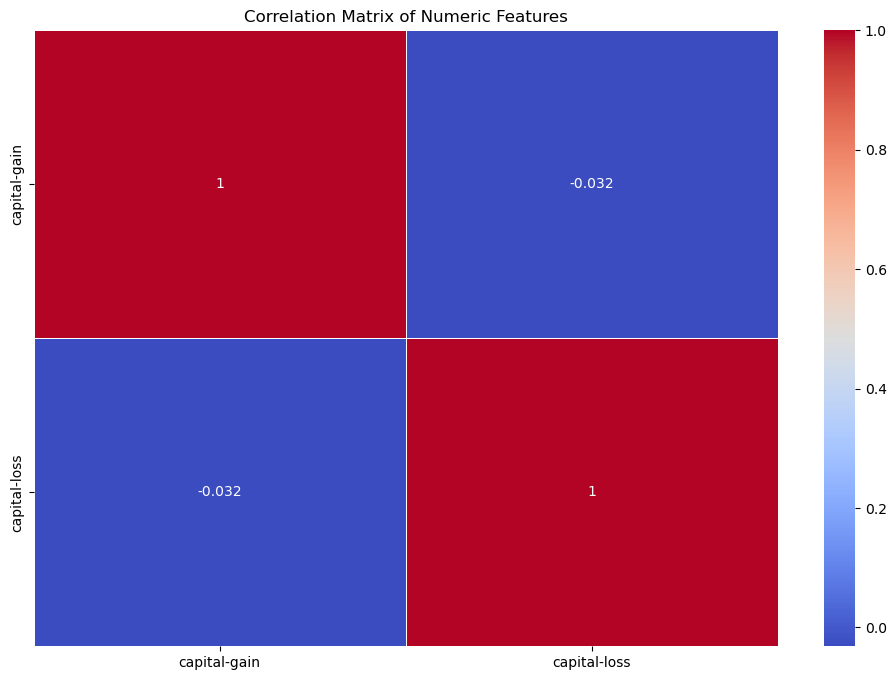

In [222]:
#OHE for numerical features only

# Select numeric columns only
#numeric_df = train_df.select_dtypes(include=['int32', 'int64', 'float64'])
numeric_df = train_df_mode.select_dtypes(include=['int32', 'int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

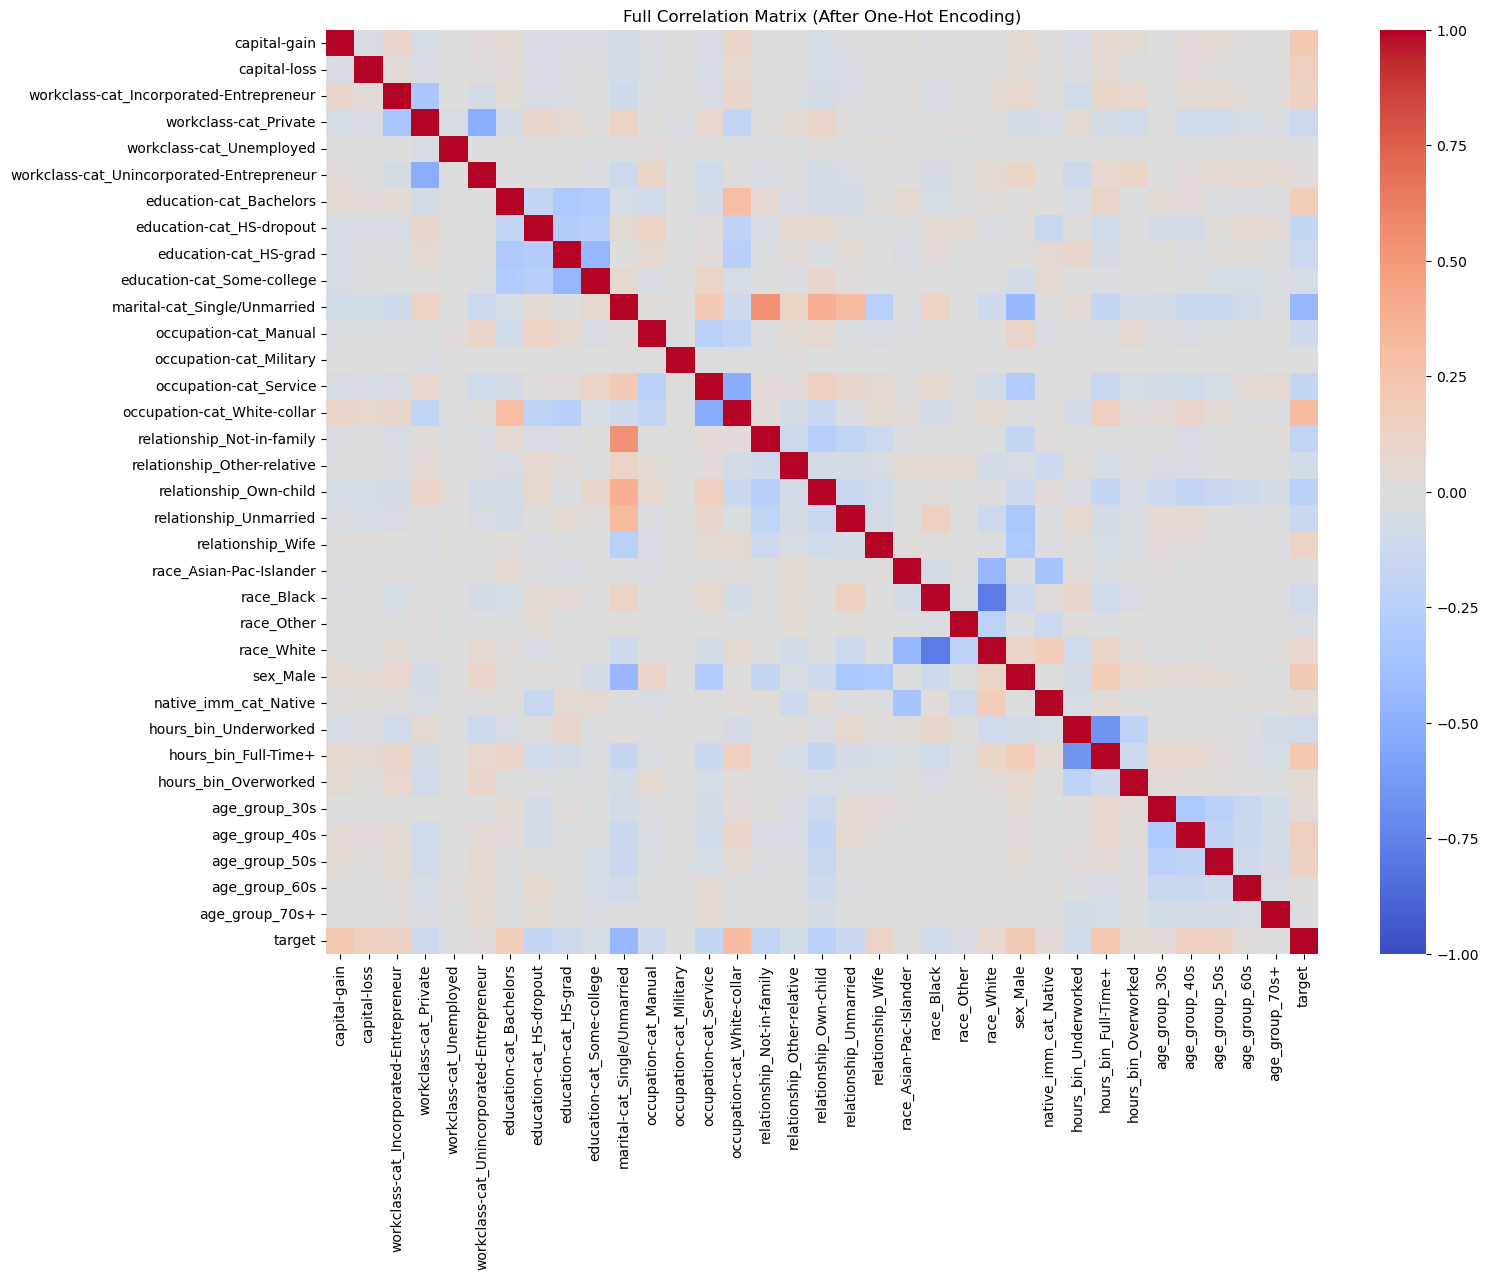

In [223]:
#OHE for correlation matrix

# One-hot encode categorical features
#encoded_df = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)
encoded_df = pd.get_dummies(train_df_mode.drop(columns=['pred']), drop_first=True)

# Add encoded label for correlation study
#encoded_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)
encoded_df['target'] = train_df_mode['pred'].apply(lambda x: 1 if x == '>50K' else 0)

corr = encoded_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Full Correlation Matrix (After One-Hot Encoding)")
plt.show()

In [224]:
# Convert pred to binary
#binary_corr_df = train_df.copy()
binary_corr_df = train_df_mode.copy()
binary_corr_df['target'] = binary_corr_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

# One-hot encode ALL features except target
encoded = pd.get_dummies(binary_corr_df.drop(columns=['pred']), drop_first=True)

# Compute correlation with target only
corr_target = encoded.corr()['target'].sort_values(ascending=False)

corr_target

target                                       1.000000
occupation-cat_White-collar                  0.305514
hours_bin_Full-Time+                         0.231183
capital-gain                                 0.223336
sex_Male                                     0.215969
education-cat_Bachelors                      0.180535
age_group_40s                                0.161920
capital-loss                                 0.150501
workclass-cat_Incorporated-Entrepreneur      0.139446
age_group_50s                                0.134815
relationship_Wife                            0.123230
race_White                                   0.085235
hours_bin_Overworked                         0.054071
native_imm_cat_Native                        0.038702
age_group_30s                                0.038103
workclass-cat_Unincorporated-Entrepreneur    0.030017
age_group_60s                                0.015963
race_Asian-Pac-Islander                      0.010600
occupation-cat_Military     

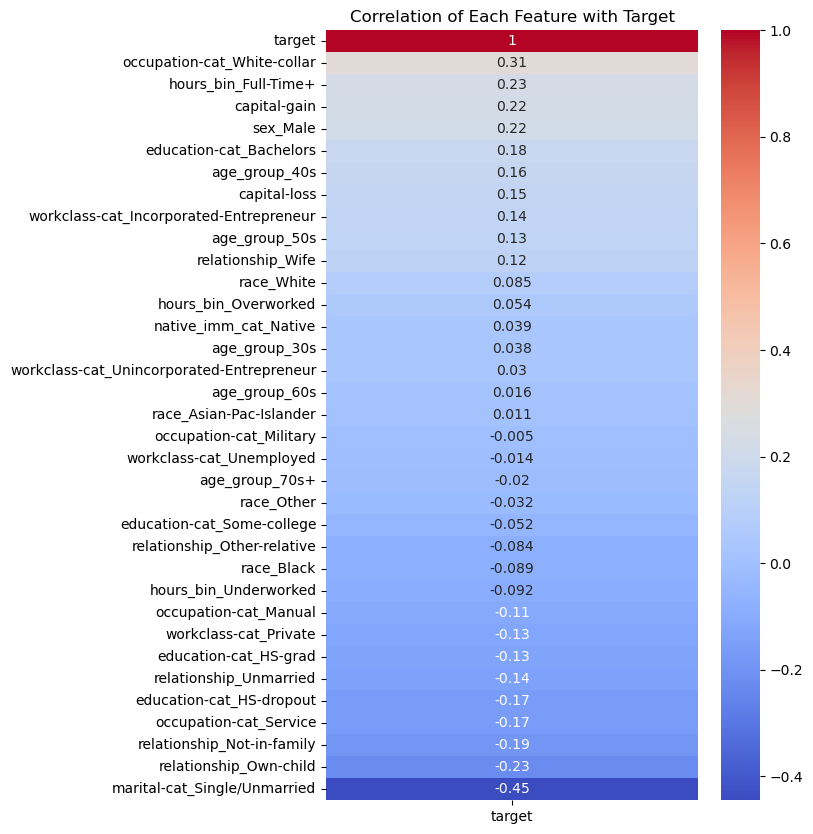

In [225]:
plt.figure(figsize=(6,10))
sns.heatmap(corr_target.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation of Each Feature with Target")
plt.show()

In [226]:
# Remove native-country
encoded_filtered = encoded.drop(columns=[col for col in encoded.columns 
                                         if col.startswith("native-country_")])

# Remove numeric columns
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                'capital-loss', 'target']  
encoded_filtered = encoded_filtered.drop(columns=[col for col in numeric_cols 
                                                  if col in encoded_filtered.columns])

# Compute correlation with target only (SORTED DESCENDING)
corr_target_only = encoded_filtered.join(binary_corr_df['target']) \
                                   .corr()['target'] \
                                   .sort_values(ascending=False)


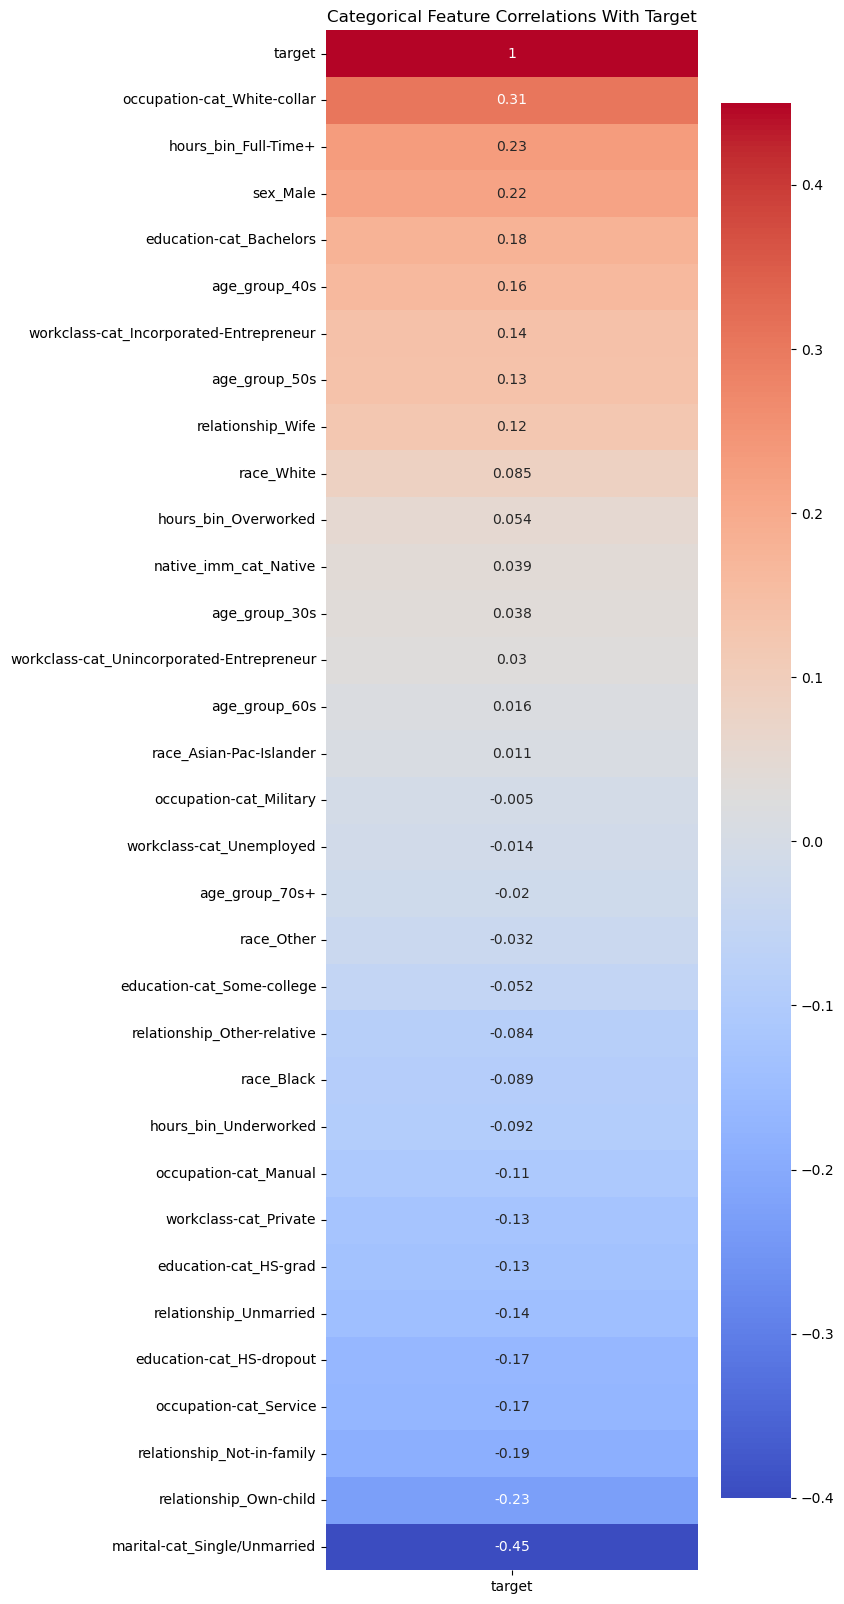

In [227]:
plt.figure(figsize=(6, 20))
sns.heatmap(corr_target_only.to_frame(),
            annot=True,
            cmap='coolwarm',
            vmin=-0.4,
            vmax=0.45)
plt.title("Categorical Feature Correlations With Target")
plt.show()

In [228]:
# Full correlation matrix among remaining categorical columns
cat_corr_matrix = encoded_filtered.corr()

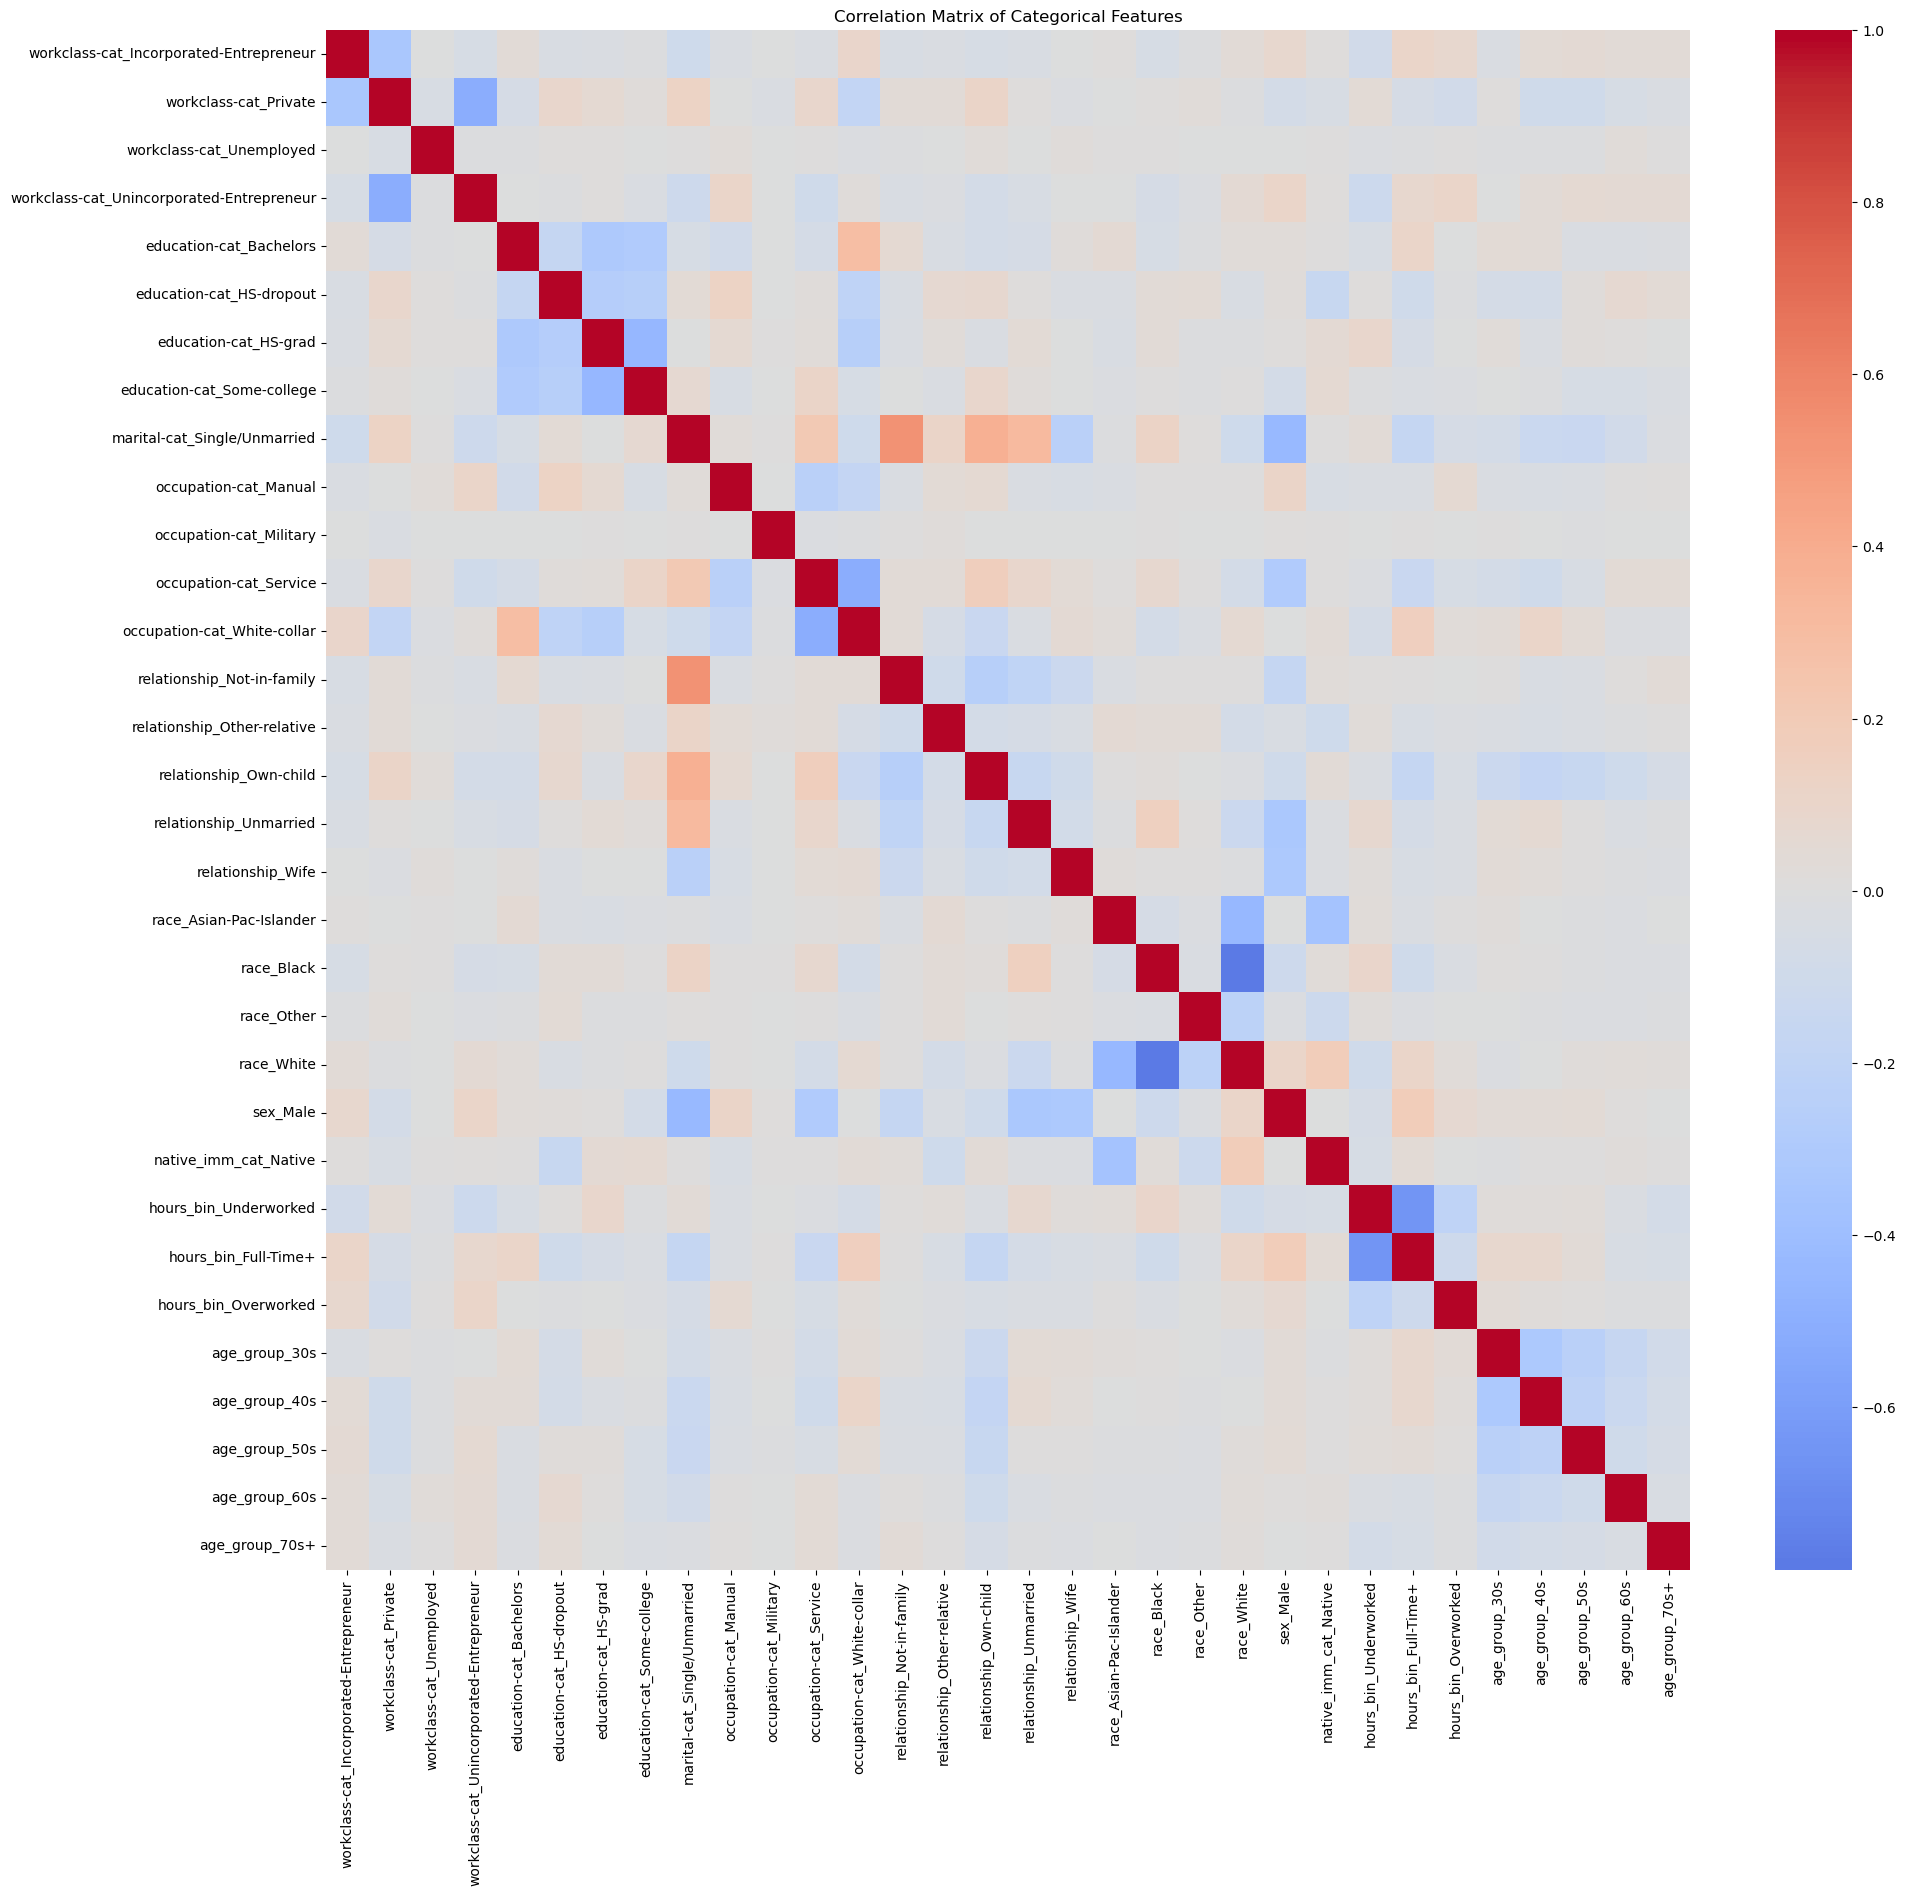

In [229]:
plt.figure(figsize=(22, 20))
sns.heatmap(cat_corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Categorical Features")
plt.show()

## Normalization --- Jieun's Part

capital-gain and capital-loss variables are extremely right-skewed with heavy zeros and a few large outliers. Standard normalization (like Min–Max or Z-score) will not work well.

In [230]:
train_df_mode

,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,capital-gain,capital-loss,native_imm_cat,pred,hours_bin,age_group
0,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,2174,0,Native,<=50K,Underworked,30s
1,Unincorporated-Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,0,0,Native,<=50K,Part-Time,50s
2,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,0,0,Native,<=50K,Underworked,30s
3,Private,HS-dropout,Married,Manual,Husband,Black,Male,0,0,Native,<=50K,Underworked,50s
4,Private,Bachelors,Married,White-collar,Wife,Black,Female,0,0,Immigrant,<=50K,Underworked,Under 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,Private,Some-college,Married,White-collar,Wife,White,Female,0,0,Native,<=50K,Underworked,Under 30
32557,Private,HS-grad,Married,Blue-collar,Husband,White,Male,0,0,Native,>50K,Underworked,40s
32558,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,0,0,Native,<=50K,Underworked,50s
32559,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,0,0,Native,<=50K,Part-Time,Under 30


In [231]:
#Log transformation (best for heavy right-skew)
#log_train_df = train_df.copy()
log_train_mode = train_df_mode.copy()

log_train_mode['capital_gain_log'] = np.log1p(log_train_mode['capital-gain'])
log_train_mode['capital_loss_log'] = np.log1p(log_train_mode['capital-loss'])

#log1p(x) handles zeros safely.
#Compresses extreme values.
#Spreads out dense low-value regions.

In [232]:
##for the testing data

#log_train_df = train_df.copy()
log_test_mode = test_df_mode.copy()

log_test_mode['capital_gain_log'] = np.log1p(log_test_mode['capital-gain'])
log_test_mode['capital_loss_log'] = np.log1p(log_test_mode['capital-loss'])


log_test_mode
print(log_test_mode['capital_gain_log'].min())
print(log_test_mode['capital_gain_log'].max())
print(log_train_mode['capital_gain_log'].min())
print(log_train_mode['capital_gain_log'].max())
print(log_train_mode['age_group'].min())
print(log_train_mode['age_group'].max())

0.0
11.512925464970229
0.0
11.512925464970229
Under 30
70s+


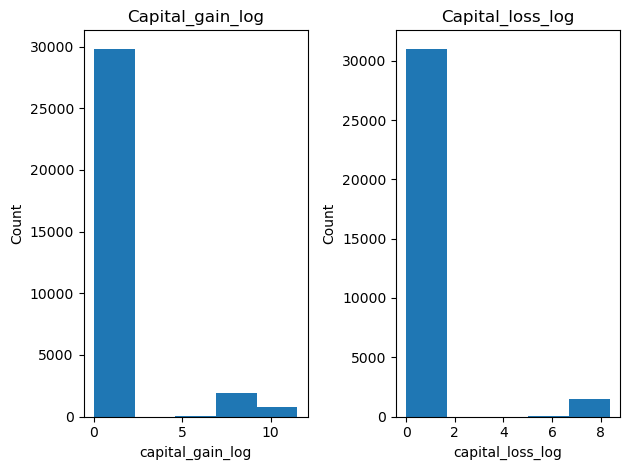

In [233]:
#capital gain
plt.subplot(1, 2, 1)
plt.hist(log_train_mode['capital_gain_log'], bins=5)
plt.title("Capital_gain_log")
plt.xlabel("capital_gain_log")
plt.ylabel("Count")

#capital loss
plt.subplot(1, 2, 2)
plt.hist(log_train_mode['capital_loss_log'], bins=5)
plt.title("Capital_loss_log")
plt.xlabel("capital_loss_log")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [234]:
log_train_df

,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,capital-gain,capital-loss,native_imm_cat,pred,hours_bin,age_group,capital_gain_log,capital_loss_log
0,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,2174,0,Native,<=50K,Underworked,30s,7.684784,0.0
1,Unincorporated-Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,0,0,Native,<=50K,Part-Time,50s,0.000000,0.0
2,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,0,0,Native,<=50K,Underworked,30s,0.000000,0.0
3,Private,HS-dropout,Married,Manual,Husband,Black,Male,0,0,Native,<=50K,Underworked,50s,0.000000,0.0
4,Private,Bachelors,Married,White-collar,Wife,Black,Female,0,0,Immigrant,<=50K,Underworked,Under 30,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,Private,Some-college,Married,White-collar,Wife,White,Female,0,0,Native,<=50K,Underworked,Under 30,0.000000,0.0
32557,Private,HS-grad,Married,Blue-collar,Husband,White,Male,0,0,Native,>50K,Underworked,40s,0.000000,0.0
32558,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,0,0,Native,<=50K,Underworked,50s,0.000000,0.0
32559,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,0,0,Native,<=50K,Part-Time,Under 30,0.000000,0.0


In [235]:
X_train_mode= log_train_mode.drop (['pred', 'capital-gain','capital-loss'],axis=1)
Y_train_mode= log_train_mode['pred']

X_test_mode = log_test_mode.drop(['pred', 'capital-gain','capital-loss'], axis=1)
Y_test_mode = log_test_mode['pred']
#X_test.isna().sum()
print(len(X_train_mode))
print(len(X_test_mode))

32537
16276


In [236]:

cat_cols = X_train_mode.select_dtypes(include=["object","category"]).columns.tolist()
print(X_train_mode.columns.tolist())
print(X_test_mode.columns.tolist())
print(train_df['hours_bin'].value_counts())

['workclass-cat', 'education-cat', 'marital-cat', 'occupation-cat', 'relationship', 'race', 'sex', 'native_imm_cat', 'hours_bin', 'age_group', 'capital_gain_log', 'capital_loss_log']
['workclass-cat', 'education-cat', 'marital-cat', 'occupation-cat', 'relationship', 'race', 'sex', 'native_imm_cat', 'hours_bin', 'age_group', 'capital_gain_log', 'capital_loss_log']
hours_bin
Underworked    17721
Full-Time+      8466
Part-Time       5240
Overworked      1110
Name: count, dtype: int64



Imbalance Method: none 
Model: Decision Tree 
test label distribution: (array(['<=50K', '>50K'], dtype=object), array([12430,  3846]))
predicted label distribution: (array(['<=50K', '>50K'], dtype=object), array([12999,  3277]))
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     12430
        >50K       0.72      0.61      0.66      3846

    accuracy                           0.85     16276
   macro avg       0.80      0.77      0.78     16276
weighted avg       0.85      0.85      0.85     16276



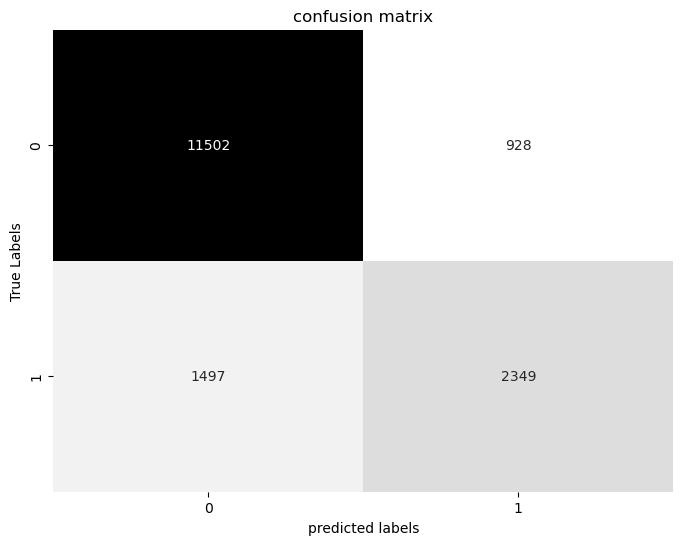


Imbalance Method: none 
Model: Random Forest Classifier 
test label distribution: (array(['<=50K', '>50K'], dtype=object), array([12430,  3846]))
predicted label distribution: (array(['<=50K', '>50K'], dtype=object), array([12968,  3308]))
              precision    recall  f1-score   support

       <=50K       0.89      0.92      0.91     12430
        >50K       0.72      0.62      0.66      3846

    accuracy                           0.85     16276
   macro avg       0.80      0.77      0.78     16276
weighted avg       0.85      0.85      0.85     16276



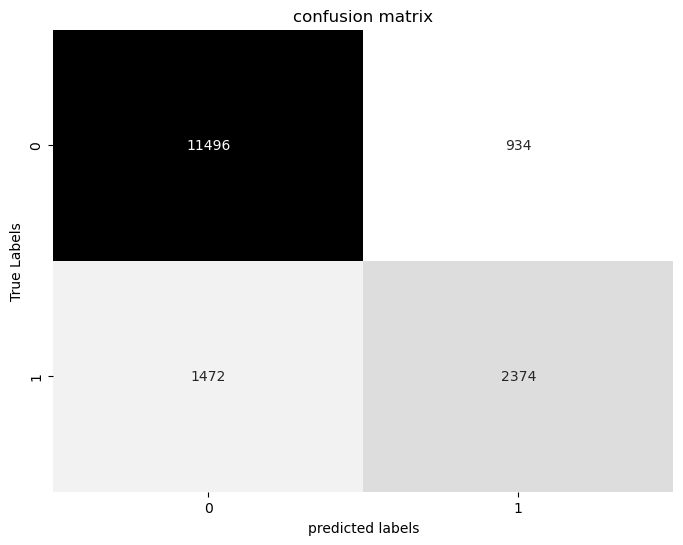


Imbalance Method: none 
Model: Logistic Regression 
test label distribution: (array(['<=50K', '>50K'], dtype=object), array([12430,  3846]))
predicted label distribution: (array(['<=50K', '>50K'], dtype=object), array([13136,  3140]))
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     12430
        >50K       0.72      0.59      0.65      3846

    accuracy                           0.85     16276
   macro avg       0.80      0.76      0.78     16276
weighted avg       0.84      0.85      0.84     16276



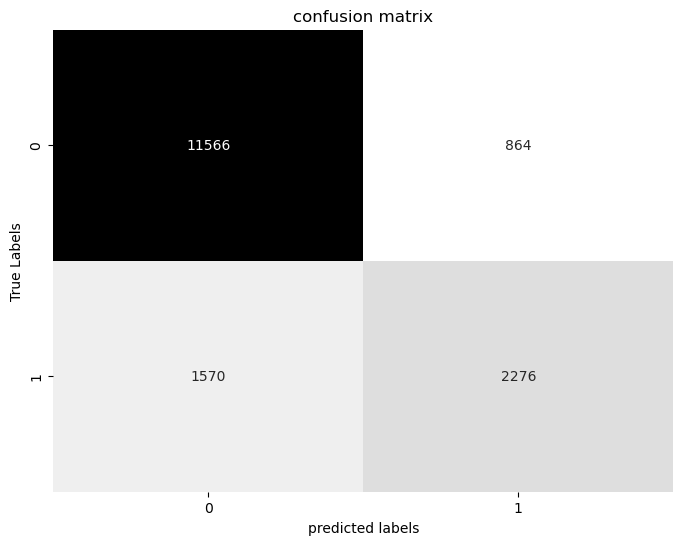


Imbalance Method: none 
Model: Bagged Decision Tree 
test label distribution: (array(['<=50K', '>50K'], dtype=object), array([12430,  3846]))
predicted label distribution: (array(['<=50K', '>50K'], dtype=object), array([10674,  5602]))
              precision    recall  f1-score   support

       <=50K       0.94      0.81      0.87     12430
        >50K       0.57      0.84      0.68      3846

    accuracy                           0.81     16276
   macro avg       0.76      0.82      0.77     16276
weighted avg       0.85      0.81      0.82     16276



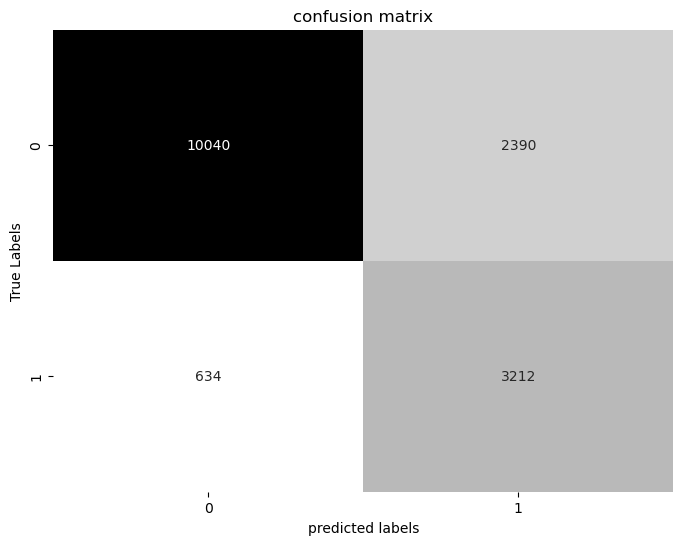


Imbalance Method: none 
Model: Bagged Random Forest 


In [ ]:
from imblearn.pipeline import Pipeline
imbalances = {
    "none" : "passthrough",
    "under" : RandomUnderSampler(random_state=42),
    "over" : RandomOverSampler(random_state=42)
}
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")

models = {
    "Decision Tree" : DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier" : RandomForestClassifier(random_state=42),
    "Logistic Regression" : LogisticRegression(max_iter=5000,solver="lbfgs"),
    "Bagged Decision Tree": BalancedBaggingClassifier(
        estimator = DecisionTreeClassifier(random_state=42), ## can make more for each 
        n_estimators= 50, 
        sampling_strategy='auto', 
        replacement = False, 
        random_state=42,
        n_jobs=1
    ),
    "Bagged Random Forest": BalancedBaggingClassifier(
        estimator = RandomForestClassifier(random_state=42), ## can make more for each 
        n_estimators= 50, 
        sampling_strategy='auto', 
        replacement = False, 
        random_state=42,
        n_jobs=1
    )
}

for imbalance_methods, method in imbalances.items():
    for model_name, clf in models.items():
        if (model_name in ["Bagged Decision Tree", "Bagged Random Forest"]) and imbalance_methods != "none":
            continue
        print (f"\nImbalance Method: {imbalance_methods} \nModel: {model_name} ")

        if model_name == "Bagged Decision Tree":
                   pipe = Pipeline(steps=[
                       ("encode", preprocess),
                       ("model", clf)
                   ])
        elif model_name == "Bagged Random Forest":
                   pipe = Pipeline(steps=[
                       ("encode", preprocess),
                       ("model", clf)
                   ])
        else: 
                   pipe = Pipeline (steps=[
                       ("encode", preprocess),
                       ("imbalances", method),
                       ("model", clf)
                   ])
        pipe.fit(X_train, Y_train)
        y_pred = pipe.predict(X_test)

        print ("test label distribution:", np.unique(Y_test, return_counts=True))
        print ("predicted label distribution:", np.unique (y_pred, return_counts=True))
        print (classification_report(Y_test, y_pred))
        
        conf= confusion_matrix(Y_test, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf, annot=True, cmap= "gray_r", fmt="d", cbar=False)
        plt.xlabel('predicted labels')
        plt.ylabel ('True Labels')
        plt.title('confusion matrix')
        plt.show()
        
        
            

In [ ]:
12430+3846

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def predictive_cat_impute(train_df, test_df, target_cols):
    """
    Predictive model categorical imputation for the columns in target_cols.
    Uses RandomForest + simple preprocessing inside each small model.
    """
    df_train = train_df.copy()
    df_test = test_df.copy()
    
    for target_col in target_cols:
        # split into known / unknown for this column
        train_known = df_train[df_train[target_col].notna()]
        train_unknown = df_train[df_train[target_col].isna()]
        test_unknown = df_test[df_test[target_col].isna()]
        
        # if nothing to impute, skip
        if train_unknown.empty and test_unknown.empty:
            continue
        
        # features: all other columns EXCEPT the one being imputed
        feature_cols = [c for c in df_train.columns if c != target_col]
        X = train_known[feature_cols]
        y = train_known[target_col]

        # basic preprocessing for this sub-task
        sub_cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        sub_num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

        sub_preprocess = ColumnTransformer(
            transformers=[
                ("cat", Pipeline(steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder(handle_unknown="ignore"))
                ]), sub_cat_cols),
                ("num", SimpleImputer(strategy="median"), sub_num_cols)
            ],
            remainder="drop"
        )

        sub_model = Pipeline(steps=[
            ("preprocess", sub_preprocess),
            ("clf", RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ))
        ])

        # fit model on known part
        sub_model.fit(X, y)

        # optional: check validation accuracy
        # (skipping here for brevity; you already printed it earlier in your notebook)

        # impute TRAIN
        if not train_unknown.empty:
            df_train.loc[train_unknown.index, target_col] = sub_model.predict(train_unknown[feature_cols])
        
        # impute TEST (if that column exists there)
        if target_col in df_test.columns and not test_unknown.empty:
            df_test.loc[test_unknown.index, target_col] = sub_model.predict(test_unknown[feature_cols])
    
    return df_train, df_test


In [ ]:
df_pred_train, df_pred_test = predictive_cat_impute(
    train_df=train_df,
    test_df=test_df,
    target_cols=cat_impute_train  # we’ll handle only those three with predictive model
)

# for consistency, still mode-impute the extra test-only cats:
for col in ['education-cat', 'marital-cat']:
    df_pred_test[col] = df_pred_test[col].fillna(df_pred_test[col].mode()[0])


In [ ]:
log_train_pred = df_pred_train.copy()
log_train_pred['capital_gain_log'] = np.log1p(log_train_pred['capital-gain'])
log_train_pred['capital_loss_log'] = np.log1p(log_train_pred['capital-loss'])

log_test_pred = df_pred_test.copy()
log_test_pred['capital_gain_log'] = np.log1p(log_test_pred['capital-gain'])
log_test_pred['capital_loss_log'] = np.log1p(log_test_pred['capital-loss'])

X_train_pred = log_train_pred.drop(columns=['pred', 'capital-gain', 'capital-loss'])
Y_train_pred = log_train_pred['pred']

X_test_pred = log_test_pred.drop(columns=['pred', 'capital-gain', 'capital-loss'])
Y_test_pred = log_test_pred['pred']


In [ ]:
from sklearn.metrics import confusion_matrix

datasets = {
    "mode": (X_train_mode, Y_train_mode, X_test_mode, Y_test_mode),
    "predictive": (X_train_pred, Y_train_pred, X_test_pred, Y_test_pred)
}

for imp_name, (X_train_curr, Y_train_curr, X_test_curr, Y_test_curr) in datasets.items():
    print("\n" + "#"*100)
    print(f"IMPUTATION METHOD: {imp_name}")
    print("#"*100)

    # recompute cat_cols for this dataset (important: hours_bin is category)
    cat_cols = X_train_curr.select_dtypes(include=['object', 'category']).columns.tolist()

    preprocess = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], remainder="passthrough")

    for imbalance_methods, method in imbalances.items():
        for model_name, clf in models.items():
            if (model_name in ["Bagged Decision Tree", "Bagged Random Forest"]) and imbalance_methods != "none":
                continue

            print(f"\nImputation: {imp_name} | Imbalance Method: {imbalance_methods} | Model: {model_name}")

            # build pipeline
            if model_name in ["Bagged Decision Tree", "Bagged Random Forest"]:
                pipe = Pipeline(steps=[
                    ("encode", preprocess),
                    ("model", clf)
                ])
            else:
                pipe = Pipeline(steps=[
                    ("encode", preprocess),
                    ("imbalances", method),
                    ("model", clf)
                ])

            pipe.fit(X_train_curr, Y_train_curr)
            y_pred = pipe.predict(X_test_curr)

            print("test label distribution:", np.unique(Y_test_curr, return_counts=True))
            print("predicted label distribution:", np.unique(y_pred, return_counts=True))
            print(classification_report(Y_test_curr, y_pred))

            conf = confusion_matrix(Y_test_curr, y_pred)
            plt.figure(figsize=(6,5))
            sns.heatmap(conf, annot=True, cmap="gray_r", fmt="d", cbar=False)
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title(f'Confusion Matrix\nImputation={imp_name}, Imbalance={imbalance_methods}, Model={model_name}')
            plt.tight_layout()
            plt.show()
